In [2]:
import numpy as np
import pandas as pd
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import plotly as py
import plotly.express as px # for visualization 
import plotly.graph_objs as go 
import plotly.offline as pyo
from plotly.subplots import make_subplots
import plotly.io as pio
pyo.init_notebook_mode(connected = True)
pio.renderers.default = "png"

import os
import zipfile
import HelperFunctions as hf

sns.set_palette('Set2')


# Overview

[M5 forecasting challenge](https://www.kaggle.com/c/m5-forecasting-accuracy/data)


## Data Description

- `calendar.csv` - Contains information about the dates on which the products are sold.

- `sales_train_validation.csv` - Contains the historical daily unit sales data per product and store `[d_1 - d_1913]`

- `sell_prices.csv` - Contains information about the price of the products sold per store and date.

- `sample_submission.csv` - The correct format for submissions. Reference the [Evaluation](https://www.kaggle.com/c/m5-forecasting-accuracy/overview/evaluation) tab for more info.

- `sales_train_evaluation.csv` - Includes sales `[d_1 - d_1941]` (labels used for the Public leaderboard)


## Task

- Forecast daily sales for the next 28 days

## Content

[Data Structure](#2.-Data-Structure)
- [Calendar](#Calendar-Summary)
- [Sale](#Sales-Summary)
- [Sell Price](#Sell-Price-Summary)


[A Single Item](#3.-A-single-item)
 - [Sales trend](#3.1-Sales-Trend)
 
 - Sales distribution
 
 - [Sell Price](#3.3-Sell-Price)


[Sales by Store](#4.-Sales-by-Store)

  - [Total sales between all the stores](#4.1-Total-sales-between-all-the-stores)
  
  - [Item Stock Distribution by dept and category](#4.2-Item-Distribution-in-one-store) 
  
  - [Sale Trend by Category accross all the stores](#4.3-Sale-Trend-by-Category-between-all-the-stores)
  
  - [Sale Trend by Dept accross all the stores](#4.4-Sale-Trend-by-Dept-between-all-the-stores)


Correlations

- Sale vs Item

- Sale vs Month/Week

- Sale vs Price

- Sale vs State

- Sale vs Snap

- Sale vs Event


Feature Importance


## Refer

- https://www.kaggle.com/anyexiezouqu/eda-chinese 
- https://www.kaggle.com/holoong9291/eda-for-m5-en
- https://www.kaggle.com/anshuls235/time-series-forecasting-eda-fe-modelling#3.-Melting-the-data


# 1. Download the Data

In [3]:
%%bash

kaggle competitions download m5-forecasting-accuracy -p data


m5-forecasting-accuracy.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
def fetch_walmat_data():
    zip_path = os.path.join('data', 'm5-forecasting-accuracy.zip')    
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data')

fetch_walmat_data()

os.listdir('./data')

['sales_train_evaluation.csv',
 'calendar.csv',
 'reduced.csv',
 'sell_prices.csv',
 'sales_train_validation.csv',
 'm5-forecasting-accuracy.zip',
 'sample_submission.csv']

# 2. Data Structure

## 2.1 Calendar

In [5]:
calendar = hf.load_calendar_data()


In [6]:
calendar.shape


(1969, 14)

In [7]:
calendar.head(10)


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0


### Date range

In [8]:
np.min(calendar['date']), np.max(calendar['date'])


('2011-01-29', '2016-06-19')

In [9]:
calendar['year'].unique()


array([2011, 2012, 2013, 2014, 2015, 2016])

In [10]:
calendar['weekday'].unique()


array(['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday'], dtype=object)

In [11]:
calendar['d'].unique()


array(['d_1', 'd_2', 'd_3', ..., 'd_1967', 'd_1968', 'd_1969'],
      dtype=object)

In [12]:
wm_yr_wk = calendar['wm_yr_wk'].unique()

wm_yr_wk[:10], wm_yr_wk[-10:], len(calendar['wm_yr_wk'].unique())


(array([11101, 11102, 11103, 11104, 11105, 11106, 11107, 11108, 11109,
        11110]),
 array([11612, 11613, 11614, 11615, 11616, 11617, 11618, 11619, 11620,
        11621]),
 282)

### Event Type/Name

In [13]:
# Event Type

pd.concat([calendar['event_type_1'], calendar['event_type_2']], axis=0).unique()


array([nan, 'Sporting', 'Cultural', 'National', 'Religious'], dtype=object)

In [14]:
# Event Name

pd.concat([calendar['event_name_1'], calendar['event_name_2']], axis=0).unique()


array([nan, 'SuperBowl', 'ValentinesDay', 'PresidentsDay', 'LentStart',
       'LentWeek2', 'StPatricksDay', 'Purim End', 'OrthodoxEaster',
       'Pesach End', 'Cinco De Mayo', "Mother's day", 'MemorialDay',
       'NBAFinalsStart', 'NBAFinalsEnd', "Father's day",
       'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay',
       'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay',
       'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear',
       'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'], dtype=object)

### Calendar Summary

This data set contains calendar information with a total of 1969 days 

- date: 2011-01-29 to 2016-06-19


- wm_yr_wk: weekday calculated by WalMart year. 
    - The first number is a flag with no special meaning in this case. 
    - The 2nd and 3rd number represents year
    - the last number represents the week
  For example, 111101 indicates the the first week in the year of 2011.


- d: the index of each day (the Foreign Key of other datasets)


- event_name_1: the event name occured on that day

- event_type_1: the type of event occured on that day

- event_name_2: another event name occured on that day

- event_type_2: the type of another event occured on that day

    - There are 4 main event types: Cultural, Sporting, National, Religious.


- snap_CA: Whether discount vouchers can be used on that day in CA.

- snap_TX: Whether discount vouchers can be used on that day in TX.

- snap_WI: Whether discount vouchers can be used on that day in WI.


## 2.2 Sales

In [15]:
df_sales = hf.load_sales_train_validation_data()


In [16]:
df_sales.shape


(30490, 1919)

In [17]:
df_sales.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [18]:
df_sales.head()


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [19]:
np.any(df_sales.isna()) # no missing value


False

### The number of items

In [20]:

item_len = len(df_sales['item_id'].unique())

print(f'{item_len} individual items in total')


3049 individual items in total


In [21]:
# select one item ranndomly, each item is sold in 10 stores across 3 states
df_sales[df_sales['item_id'] == 'HOBBIES_1_010']


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
9,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,0,...,1,0,0,0,0,0,0,2,0,2
3058,HOBBIES_1_010_CA_2_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_2,CA,0,0,1,1,...,0,1,1,0,0,0,0,1,3,1
6107,HOBBIES_1_010_CA_3_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_3,CA,1,0,2,0,...,2,0,0,0,2,0,1,2,2,1
9156,HOBBIES_1_010_CA_4_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_4,CA,2,0,1,0,...,0,0,0,0,0,0,0,0,1,1
12205,HOBBIES_1_010_TX_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,TX_1,TX,0,0,0,0,...,1,0,1,1,0,0,0,1,0,1
15254,HOBBIES_1_010_TX_2_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,TX_2,TX,0,2,0,1,...,0,0,1,0,2,0,1,0,0,1
18303,HOBBIES_1_010_TX_3_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,TX_3,TX,1,0,0,1,...,2,1,2,2,0,0,0,1,0,0
21352,HOBBIES_1_010_WI_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,WI_1,WI,1,2,0,0,...,1,0,0,0,2,0,0,0,1,2
24401,HOBBIES_1_010_WI_2_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,WI_2,WI,0,0,0,1,...,0,0,0,1,1,0,0,0,1,2
27450,HOBBIES_1_010_WI_3_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,WI_3,WI,0,2,0,0,...,1,0,0,0,1,0,0,1,1,0


### Distribution of Product Categories

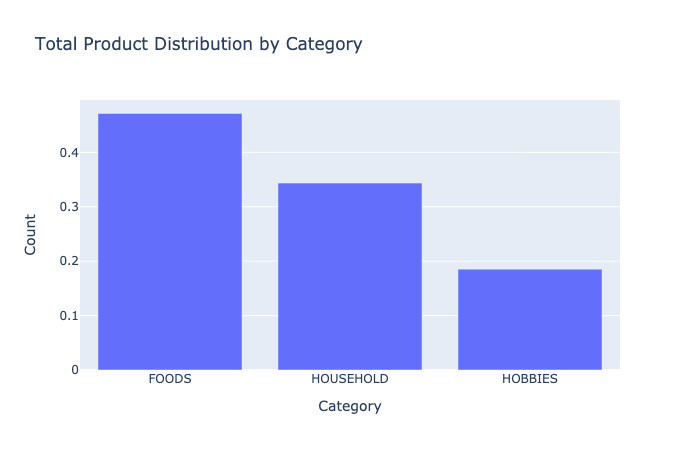

In [22]:
category_num = df_sales.groupby('cat_id')['id'].count()
category_num = pd.DataFrame({
    'Category': category_num.index,
    'Count': category_num.values/(np.sum(category_num.values))
})

fig = px.bar(category_num, 
             x='Category', y='Count', 
             width=600, height=320, title='Total Product Distribution by Category')
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()


In [23]:
df_sales['state_id'].value_counts()


CA    12196
WI     9147
TX     9147
Name: state_id, dtype: int64

In [24]:
df_sales['store_id'].value_counts()


WI_2    3049
CA_3    3049
WI_1    3049
CA_2    3049
TX_2    3049
CA_1    3049
WI_3    3049
TX_1    3049
TX_3    3049
CA_4    3049
Name: store_id, dtype: int64

### Sales Summary

There are a total of 30490 rows and 1919 columns, including 3049 individual items across 10 stores located in 3 states.

There is no missing value.

Half of the products sold in Walmat are food, followed by household(33%) and hobbies(17%).

- id: the id of each product item in each store, {item_id}_{store_id}

- item_id: the id of each product item, {dept_id}_{index}

- dept_id: the department id, {cate_id}_{index}

- cat_id: the category of a product, {cate_id}

- store_id: {store_id}_{index}

- state_id: {store_id}

- d_n: the sales amount on nth day


## 2.3 Sell Prices

In [25]:
df_sell_price = hf.load_sell_price_data()


In [26]:
df_sell_price.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [27]:
df_sell_price.shape


(6841121, 4)

In [28]:
df_sell_price.head()


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [29]:
np.any(df_sell_price['sell_price'].isna()) # no missing value


False

In [30]:
df_sell_price['sell_price'].describe()    


count    6.841121e+06
mean     4.410952e+00
std      3.408814e+00
min      1.000000e-02
25%      2.180000e+00
50%      3.470000e+00
75%      5.840000e+00
max      1.073200e+02
Name: sell_price, dtype: float64

In [31]:
len(df_sell_price['item_id'].unique()), len(df_sell_price['wm_yr_wk'].unique()), 7 * 281 + 2


(3049, 282, 1969)

### Sell Price Summary

This file contins the information about the price of the products sold per store per week.

There's no missing value.


- store_id: store id


- item_id: product id


- wm_yr_wk: the same as previous field


- sellprice: The price of the products sold per store per week


# Melt Sales Data

In [32]:
df = hf.meltM5(df_sales)


In [62]:
df = pd.merge(df, calendar, on='d', how='left')

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 58327370 entries, 0 to 58327369
Data columns (total 21 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   id            object
 1   item_id       object
 2   dept_id       object
 3   cat_id        object
 4   store_id      object
 5   state_id      object
 6   d             object
 7   sold          int64 
 8   date          object
 9   wm_yr_wk      int64 
 10  weekday       object
 11  wday          int64 
 12  month         int64 
 13  year          int64 
 14  event_name_1  object
 15  event_type_1  object
 16  event_name_2  object
 17  event_type_2  object
 18  snap_CA       int64 
 19  snap_TX       int64 
 20  snap_WI       int64 
dtypes: int64(8), object(13)
memory usage: 9.6+ GB


In [33]:
time_unit = 'd' # day, week, month, season, year, specail day


In [34]:
def getRandomItem():
    return np.random.choice(df_sales['item_id'].unique())

# select one item ranndomly, each item is sold in 10 stores
def getDailySaleByItem(item_id=None):
    if not item_id:
        item_id = getRandomItem()

    item_daily_sale = df[df['item_id'] == item_id]
    
    return item_daily_sale, item_id



def getRandomStore():
    return np.random.choice(df_sales['store_id'].unique())

# select one item ranndomly, each item is sold in 10 stores across 3 states
def getDailySaleByStore(store_id=None):
    if not store_id:
        store_id = getRandomStore()

    store_daily_sale = df[df['store_id'] == store_id]
    
    return store_daily_sale, store_id


# def rollingMeanSales(item_daily_sale, windowSize=7): 
#     item_daily_sale['rolling_mean_'+str(windowSize)]= item_daily_sale.groupby(['id'])['sold'].transform(lambda x: x.rolling(windowSize).mean())
#     return item_daily_sale


# 3. A single item

In [35]:
# randomly pick an item to look at its daily sale
item_daily_sale, item_id = getDailySaleByItem('HOBBIES_1_001')

# check
item_daily_sale[item_daily_sale['store_id'] == 'CA_1']


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold
9096,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
39586,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0
70076,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0
100566,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0
131056,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0
...,...,...,...,...,...,...,...,...
58184016,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1909,1
58214506,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1910,3
58244996,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1911,0
58275486,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1912,1


## 3.1 Sales Trend

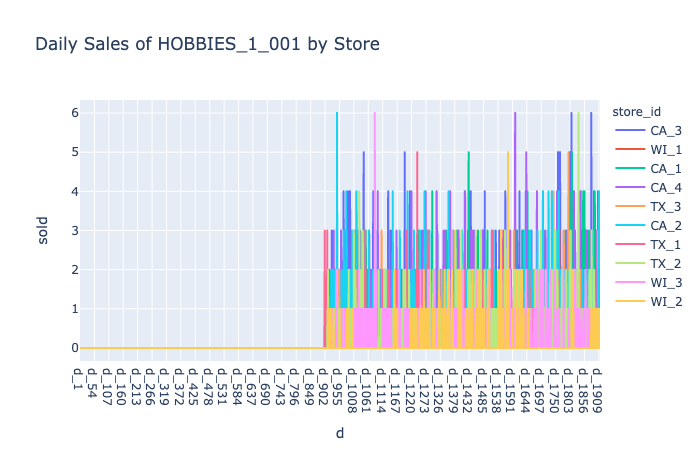

/Users/wuxiaopan/work/GroupWork/AML/HelperFunctions.py:159: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



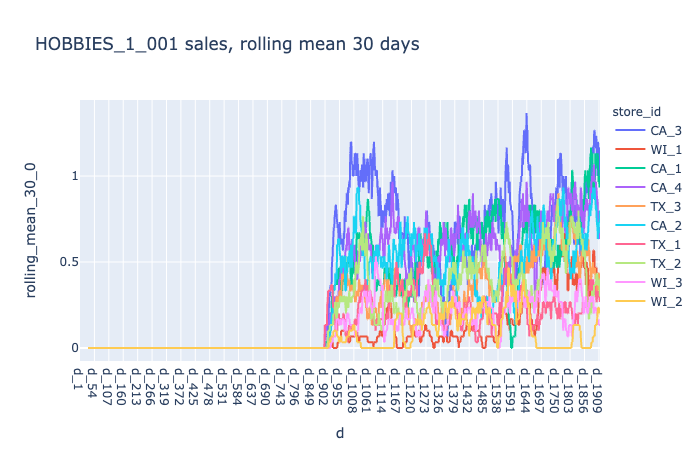

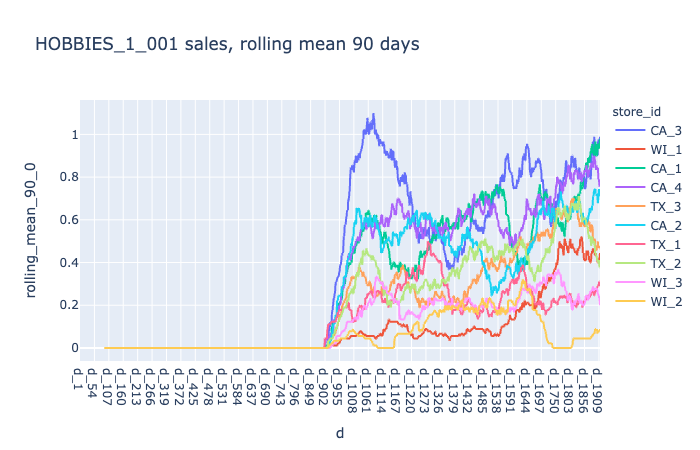

In [36]:
fig = px.line(
    item_daily_sale, 
    x=time_unit, y='sold', color='store_id', 
    title='Daily Sales of ' + item_id + ' by Store')

fig.show()

# rolling
window_size = [30, 90]
shift=0
for s in window_size:
    item_daily_sale_rolling = hf.rollingMeanDemandFeature(item_daily_sale, s, shift)
    fig = px.line(
        item_daily_sale_rolling, 
        x=time_unit, y='rolling_mean_' + str(s)+'_'+str(shift), color='store_id', 
        title=item_id + ' sales, rolling mean ' + str(s) + ' days')
    fig.show()



### Sale Trend Summary

- Some items don't have sales until some day(e.g. d_900)


- The sale pattern is clear in seasonal sales.


- Sales are very low.


## 3.2 Sales distribution

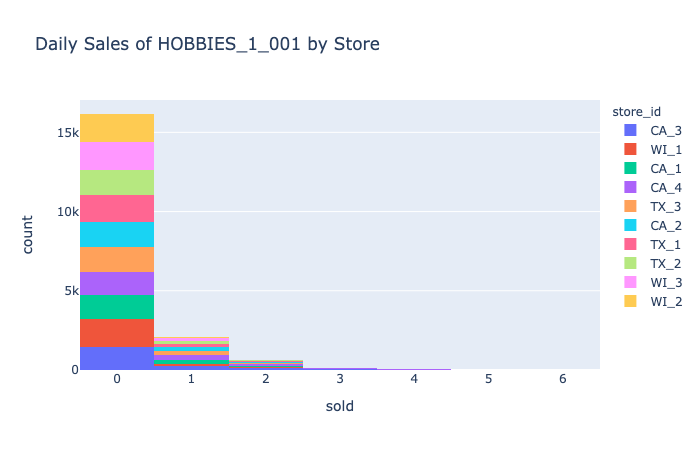

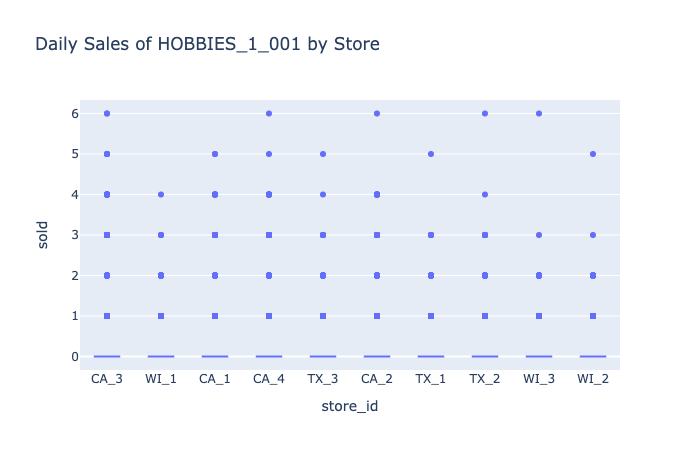

/Users/wuxiaopan/opt/anaconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




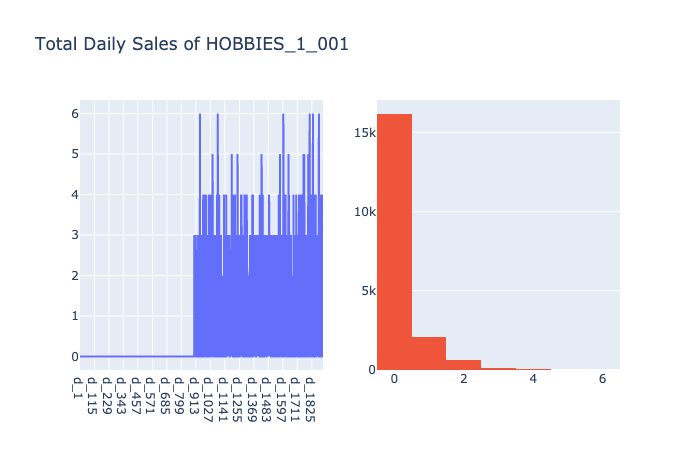

In [37]:
fig = px.histogram(
    item_daily_sale, 
    x="sold", color='store_id',   
    width=320, height=320, title='Daily Sales of ' + item_id + ' by Store'
)
fig.show()

fig = px.box(
    item_daily_sale, 
    x="store_id", y="sold", 
    width=320, height=320,
    title='Daily Sales of ' + item_id + ' by Store')
fig.show()


# total
fig = make_subplots(rows=1, cols=2)
fig.add_trace(
    go.Line(x=item_daily_sale[time_unit], y=item_daily_sale['sold']),
    row=1, col=1
)
fig.add_trace(
    go.Histogram(x=item_daily_sale["sold"]),
    row=1, col=2
)

fig.update_layout(showlegend=False, title_text='Total Daily Sales of ' + item_id)
fig.show()


## 3.3 Sell Price

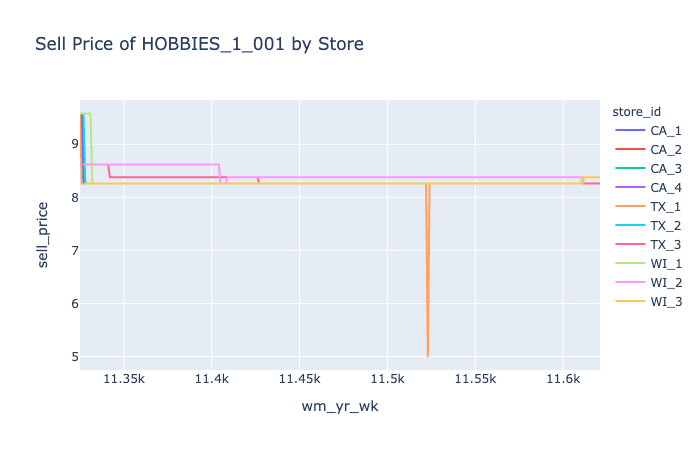

In [38]:

item_sell_price = df_sell_price[df_sell_price['item_id'] == item_id]


fig = px.line(
    item_sell_price, 
    x='wm_yr_wk', y='sell_price', color='store_id', 
    title='Sell Price of ' + item_id + ' by Store')
fig.show('') # notebook_connected


### Sell price summary

Overall, the prices are stable, except several occaional price cut.


# 4. Sales by Store


## 4.1 Total sales between all the stores

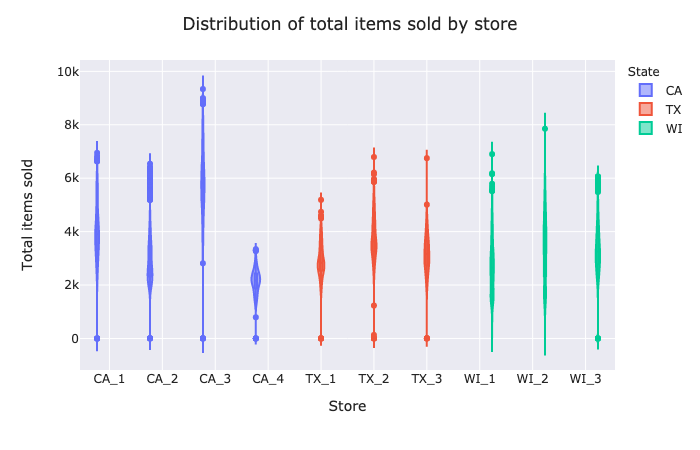

In [39]:
group = df.groupby(['d', 'state_id', 'store_id'], as_index=False)['sold'].sum().dropna()
fig = px.violin(group, x='store_id', color='state_id', y='sold', box=True)


fig.update_xaxes(title_text='Store')
fig.update_yaxes(title_text='Total items sold')
fig.update_layout(template='seaborn',title='Distribution of total items sold by store', legend_title_text='State')
fig.show()


## 4.2 Item Distribution in one store

In [40]:
store_daily_sale, store_id = getDailySaleByStore()

# check
store_daily_sale.head()


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold
4,HOBBIES_1_070_WI_3_validation,HOBBIES_1_070,HOBBIES_1,HOBBIES,WI_3,WI,d_1,0
9,HOBBIES_1_123_WI_3_validation,HOBBIES_1_123,HOBBIES_1,HOBBIES,WI_3,WI,d_1,0
14,HOBBIES_1_240_WI_3_validation,HOBBIES_1_240,HOBBIES_1,HOBBIES,WI_3,WI,d_1,0
16,FOODS_2_186_WI_3_validation,FOODS_2_186,FOODS_2,FOODS,WI_3,WI,d_1,0
18,HOUSEHOLD_2_324_WI_3_validation,HOUSEHOLD_2_324,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,d_1,0


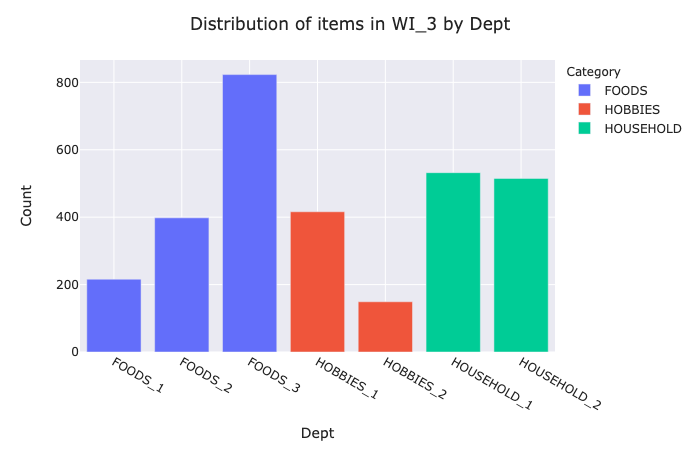

In [41]:
store_sales = df_sales.loc[df_sales['store_id'] == store_id]
group = store_sales.groupby(['cat_id', 'dept_id'], as_index=False)['item_id'].count()

fig = px.bar(group, x='dept_id', color='cat_id', y='item_id')
fig.update_xaxes(title_text='Dept')
fig.update_yaxes(title_text='Count')
fig.update_layout(template='seaborn',title='Distribution of items in ' + store_id + ' by Dept', legend_title_text='Category')
fig.show()


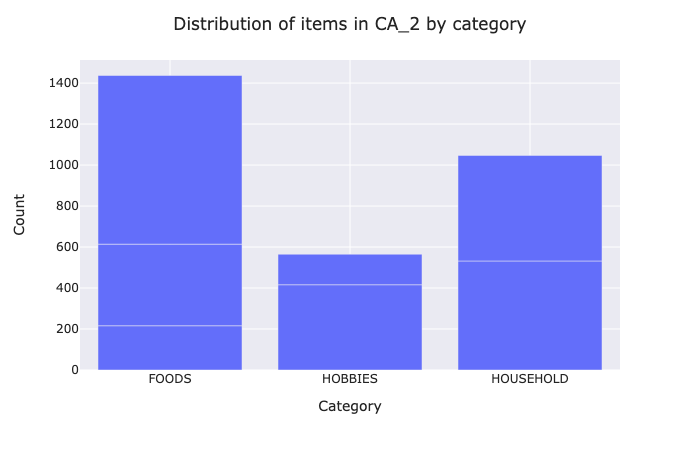

In [42]:
g = store_sales.groupby('cat_id', as_index=False)['item_id'].count()

fig = px.bar(group, x='cat_id',  y='item_id')
fig.update_xaxes(title_text='Category')
fig.update_yaxes(title_text='Count')
fig.update_layout(template='seaborn', title='Distribution of items in ' + store_id + ' by category')
fig.show()


- 'CA_3' has the highest sales while 'CA_4' has the smallest among all the stores.



## 4.3 Sale Trend by Category between all the stores

/Users/wuxiaopan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning:

FixedFormatter should only be used together with FixedLocator

/Users/wuxiaopan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning:

FixedFormatter should only be used together with FixedLocator

/Users/wuxiaopan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning:

FixedFormatter should only be used together with FixedLocator



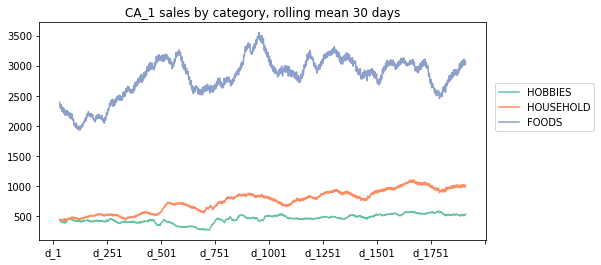

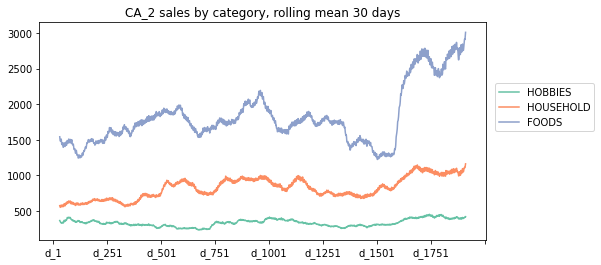

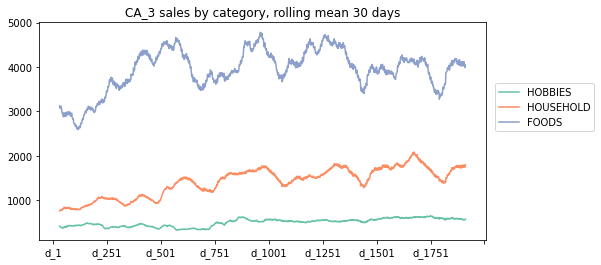

In [89]:
stores = df_sales['store_id'].unique()[:3]

for s in stores:
    plt.figure(figsize=(8, 4))
    store_sales = df_sales.loc[df_sales['store_id'] == s]
    for d in store_sales['cat_id'].unique():
        store_sales_d = store_sales.loc[store_sales['cat_id'] == d]
        store_sales_d.iloc[:, 6:].sum().rolling(30).mean().plot(label=d)
    plt.title(s + ' sales by category, rolling mean 30 days')
    plt.legend(loc=(1.02, 0.5))


## 4.4 Sale Trend by Dept between all the stores

/Users/wuxiaopan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning:

FixedFormatter should only be used together with FixedLocator

/Users/wuxiaopan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning:

FixedFormatter should only be used together with FixedLocator

/Users/wuxiaopan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning:

FixedFormatter should only be used together with FixedLocator



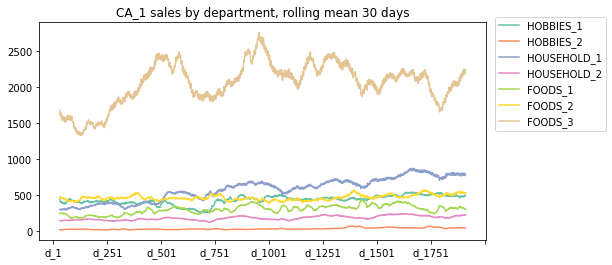

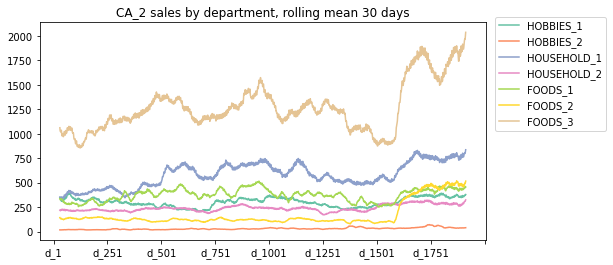

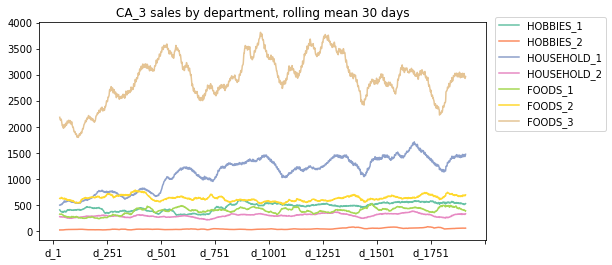

In [44]:
stores = df_sales['store_id'].unique()[:3]

for s in stores:
    plt.figure(figsize=(8, 4))
    store_sales = df_sales.loc[df_sales['store_id'] == s]

    for d in store_sales['dept_id'].unique():
        store_sales_d = store_sales.loc[store_sales['dept_id'] == d]
        store_sales_d.iloc[:, 6:].sum().rolling(30).mean().plot(label=d)
    plt.title(s + ' sales by department, rolling mean 30 days')
    plt.legend(loc=(1.02, 0.5))



# 5. Correlations

## 5.1 Sale vs Item in a store


In [117]:
sale_by_store, store_id = getDailySaleByStore()


<AxesSubplot:xlabel='item_id'>

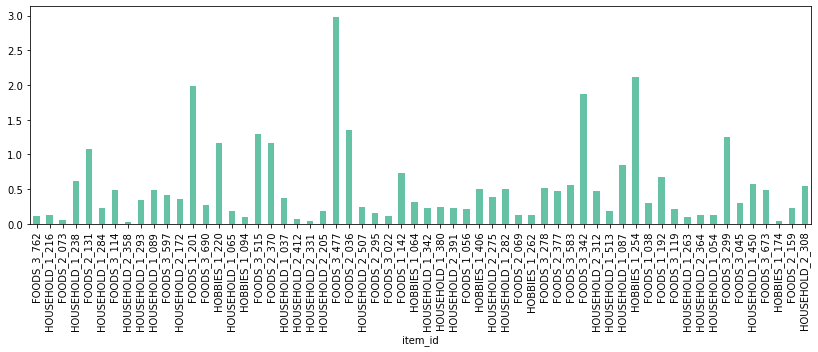

In [118]:
f, ax = plt.subplots(figsize=(14, 4))

sale_by_store.groupby('item_id')['sold'].mean().sample(60).plot(kind='bar')


- Obviously, different items has much different sales.



## 5.2 Average Sale vs Month/Weekday in a store


Text(0, 0.5, 'Avearage sales')

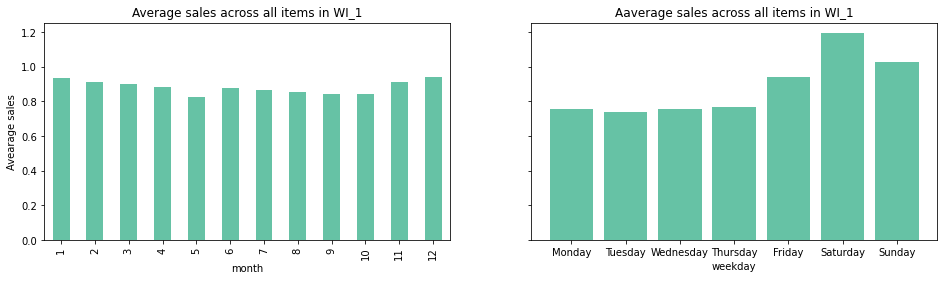

In [212]:
week_id = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

f, ax = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

sale_by_store.groupby('month')['sold'].mean().plot(kind='bar', ax=ax[0])
ax[0].set_title('Average sales across all items in ' + store_id)
ax[0].set_xlabel('month')
ax[0].set_ylabel('Avearage sales')

week_sale = sale_by_store.groupby('weekday')['sold'].mean()
ax[1].bar(week_id, week_sale[week_id])
ax[1].set_title('Aaverage sales across all items in ' + store_id)
ax[1].set_xlabel('weekday')
ax[1].set_ylabel('Avearage sales')



- The average sale by month across all the items is more or less constant in a store while the avg sales by weekday varies much.


- There are more sales on Friday, Saturday and Sunday.


In [185]:
# group_year_month_store = sale_by_store.groupby(['year', 'month'])['sold'].mean().reset_index()

# group_year_month_store_year = group_year_month_store[group_year_month_store['year'] == 2014]
# f, ax = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
# ax[0].bar(group_year_month_store_year['month'], group_year_month_store_year['sold'])

# group_year_month_store['year_x'] = pd.to_datetime(group_year_month_store['year'], format='%Y')
# fig = px.bar(group_year_month_store, x='month', color='year_x', y='sold', barmode='group')
# fig.update_xaxes(title_text='Dept')
# fig.update_yaxes(title_text='Count')
# fig.update_layout(template='seaborn',title='Distribution of items in ' + store_id + ' by Dept', legend_title_text='Category')
# fig.show('notebook_connected')


### 5.2 Average Sale vs Month/Weekday in a single item in a store

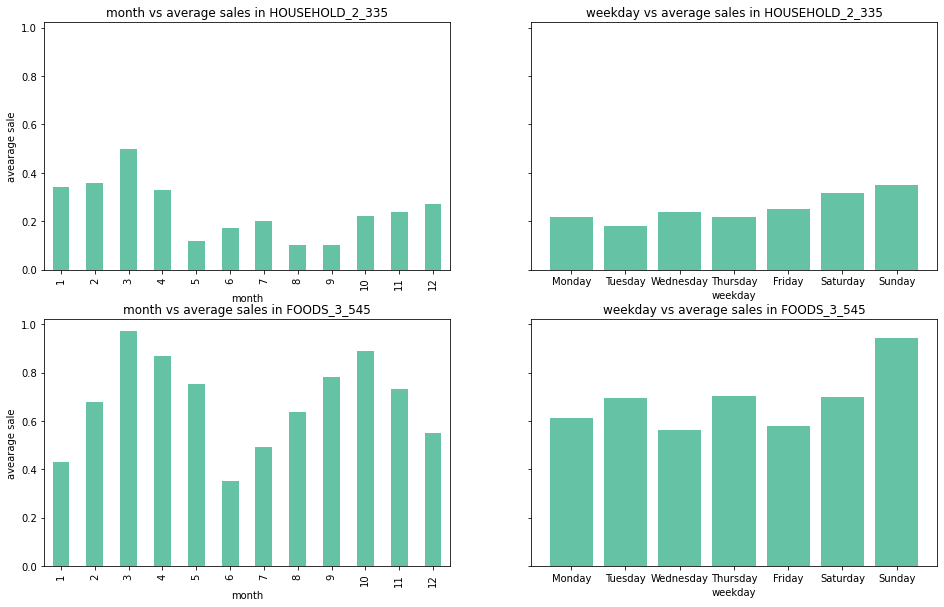

In [209]:
rand_items = np.random.choice(sale_by_store['item_id'].unique(), 2)

f, ax = plt.subplots(1 * len(rand_items), 2, figsize=(16, 5 * len(rand_items)), sharey=True)

for (i, rand_item) in enumerate(rand_items):
    sale_by_store[sale_by_store['item_id'] == rand_item].groupby('month')['sold'].mean().plot(kind='bar', ax=ax[i, 0])
    ax[i, 0].set_title('month vs average sales in ' + rand_item)
    ax[i, 0].set_xlabel('month')
    ax[i, 0].set_ylabel('avearage sale')

    week_sale = sale_by_store[sale_by_store['item_id'] == rand_item].groupby('weekday')['sold'].mean()
    ax[i, 1].bar(week_id, week_sale[week_id])
    ax[i, 1].set_title('weekday vs average sales in ' + rand_item)
    ax[i, 1].set_xlabel('weekday')
    ax[i, 1].set_ylabel('avearage sale')


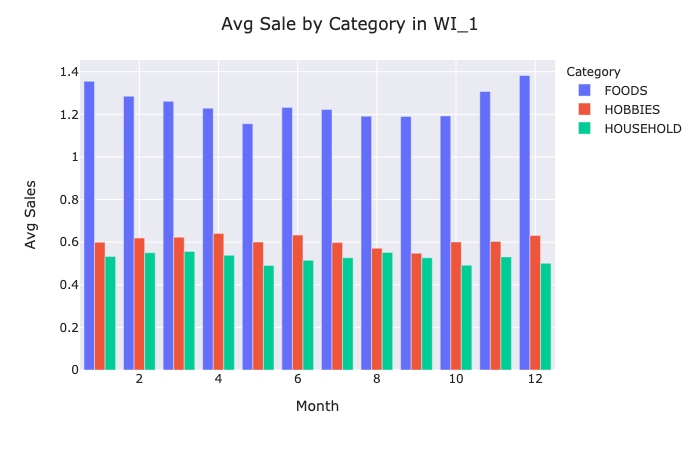

In [213]:
rand_items = sale_by_store['cat_id'].unique()
group = sale_by_store.groupby(['cat_id', 'month'])['sold'].mean().reset_index()
fig = px.bar(group, x='month', color='cat_id', y='sold', barmode='group')
fig.update_xaxes(title_text='Month')
fig.update_yaxes(title_text='Avg Sales')
fig.update_layout(template='seaborn',title='Avg Sale by Category in ' + store_id, legend_title_text='Category')
fig.show()


- Typically, food has the largest sale in each month.


- Sales peak or fall in several particualr months for some items.


- Typically, there are more sales on Friday, Saturday and Sunday.


- Sometimes, other weekdays have the highest sales, it may be because it is a holiday on that day.


### 5.3 Sale vs Price


### 5.4 Sale vs State

### 5.5 Sale vs Snap


### 5.5 Sale vs Event
